<h1 class="heading">TEST — 1</h1>
<h1>Notebook for testing JSBSim simulations functionalities</h1>

<h6 class="author"> — <b style="color:rgb(0,51,102);">Agostino De Marco</b>, <i>University of Naples Federico II</i></h6>

In [1]:
% run ./python/nb_init.py
% matplotlib inline

import numpy as np

import geography as geo
import data_handling as dh
from property_map import pmap
from MCSim import *

## Simulation setup

In [2]:
# Turbine diameter
D_t = 120 #m

# Assign turbine Lat-Lon coordinates and height
Lat_t = 53.153588 #deg
Lon_t = 8.162655  #deg
H_t   = 120       #m

# Calculate turbine UTM coordinates
X_t, Y_t, zone_num, zone_lett = utm.from_latlon(Lat_t, Lon_t)
print("X_t =  {0:.14f} m (Easting coord.)".format(X_t), sep="")
print("Y_t =  {0:.14f} m (Northing coord.)".format(Y_t), sep="")


# List of distances from the disk, in terms of turbine diameters
# The length of the list is equal to the number of simulations for each speed value
nD_t = [0] #[0,1,2,3,4,5,10,15,20]

X_t =  444005.64156725001521
Y_t =  5889683.58956928178668

# Calculate aircraft initial positions, relative to turbine, in UTM
X0 = list(X_t + np.asarray(nD_t)*D_t)
Y0 = Y_t - 1500

# Calculate waypoints positions in UTM
X1 = X0; Y1 = Y_t + 1500

# Convert such positions to Lat-Lon coordinates
def LatLon_from_utm(X, Y, zone_num, zone_lett):
    LatLon = [utm.to_latlon(X[i], Y, zone_num, zone_lett) for i in range(len(nD_t))]
    Lat = [LatLon[i][0] for i in range(len(X))] #deg
    Lon = [LatLon[i][1] for i in range(len(X))] #deg
    return Lat, Lon

Lat0, Lon0 = LatLon_from_utm(X0, Y0, zone_num, zone_lett)
Lat1, Lon1 = LatLon_from_utm(X1, Y1, zone_num, zone_lett)

X_t =  444005.64156725001521 m (Easting coord.)
Y_t =  5889683.58956928178668 m (Northing coord.)


In [3]:
N = 1
script     = 'c172xmod_00_temporary_test_sim'
autopilot  = 'c172ap_unina_mod'
output_fol = '00_temporary_test_sim'

# Creating instance of the class
Sim_test = WRSimFamily(N, seed_name   = script,
                          autopilot_name = autopilot,
                          out_foldername = output_fol,
                          port_num=1026)

# Initial positions
Sim_test.generate_series('latitude', 'from_list', Lat0)
Sim_test.generate_series('longitude', 'from_list', Lon0)

# Waypoint positions
Sim_test.generate_series('guidance/target-wp-latitude-rad-final',    'from_list', np.radians(Lat1))
Sim_test.generate_series('guidance/target-wp-longitude-rad-final',   'from_list', np.radians(Lon1))

# Flight parameters
h_ft    = Sim_test.set_value('altitude', (138*unit.m).to(unit.ft).magnitude)
psi_deg = Sim_test.set_value('psi', 0)
V_kts   = Sim_test.set_value('vt', 50)

In [4]:
Sim_test.launch_mc_sim(log='off', system='windows')
#! ../JSBSim/JSBSim --script=../JSBSim/scripts/c172xmod_00_temporary_test_sim --root=../JSBSim/ > ../JSBSim/log_test.txt

[Windows] Running all instances (in background???)...
[Windows] cmd: .\JSBSim\JSBSim.exe --root=./JSBSim/ --script=scripts/c172xmod_00_temporary_test_sim_port1026_0001.xml > ./JSBSim/aircraft/c172x_unina_mod_port1026_0001/log_port1026_0001.txt & 
Organizing files and folders...
Total time required: 2.03 s


In [5]:
GrA = Sim_test.extract_post_group(list(range(1,N+1)),'A')
GrA.get_traj_in_UTM()

Total time required: 0.60 s


Total time required: 1.43 s


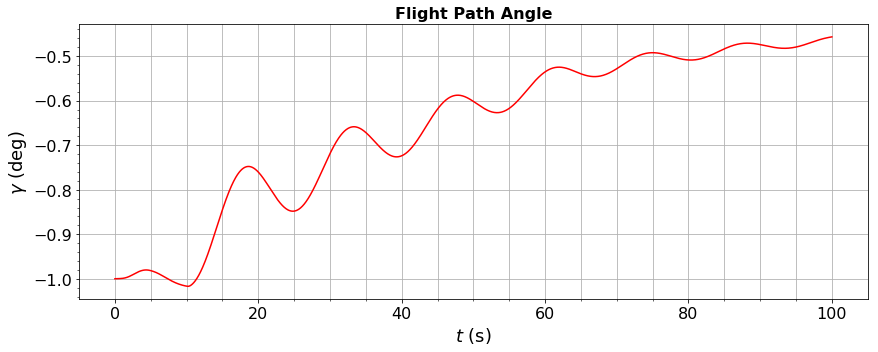

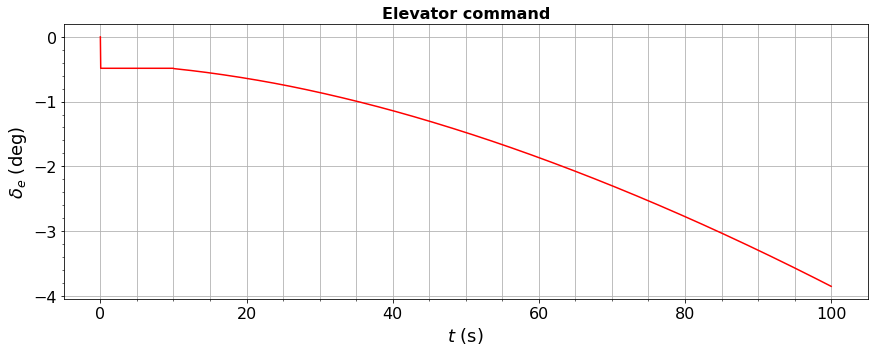

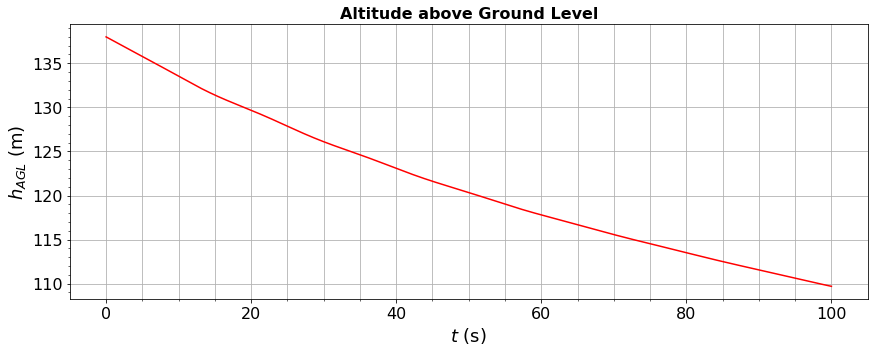

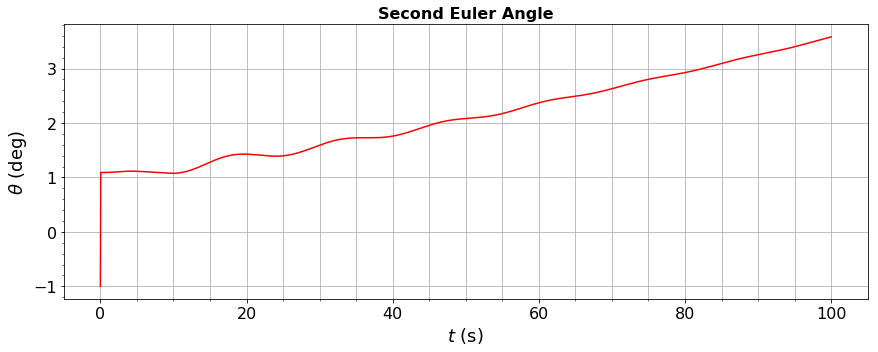

In [6]:
GrA.plot_vars('gamma_deg','delta_e','h_agl_m','theta_deg')

Total time required: 0.65 s


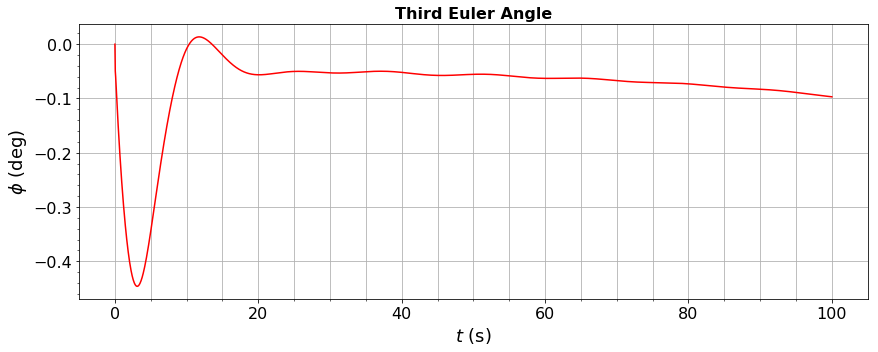

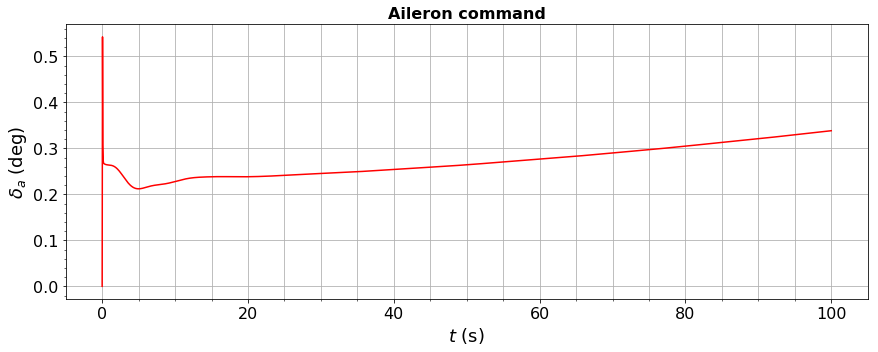

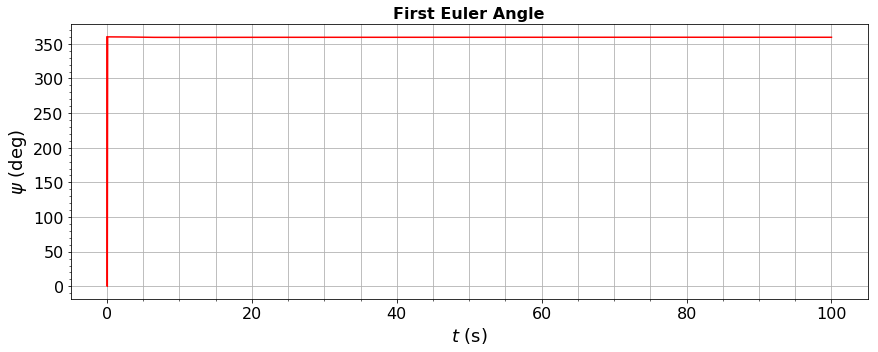

In [7]:
#GrA.plot_vars('delta_a','delta_r','delta_e','delta_t')
GrA.plot_vars('phi_deg','delta_a','psi_deg')

Total time required: 0.58 s


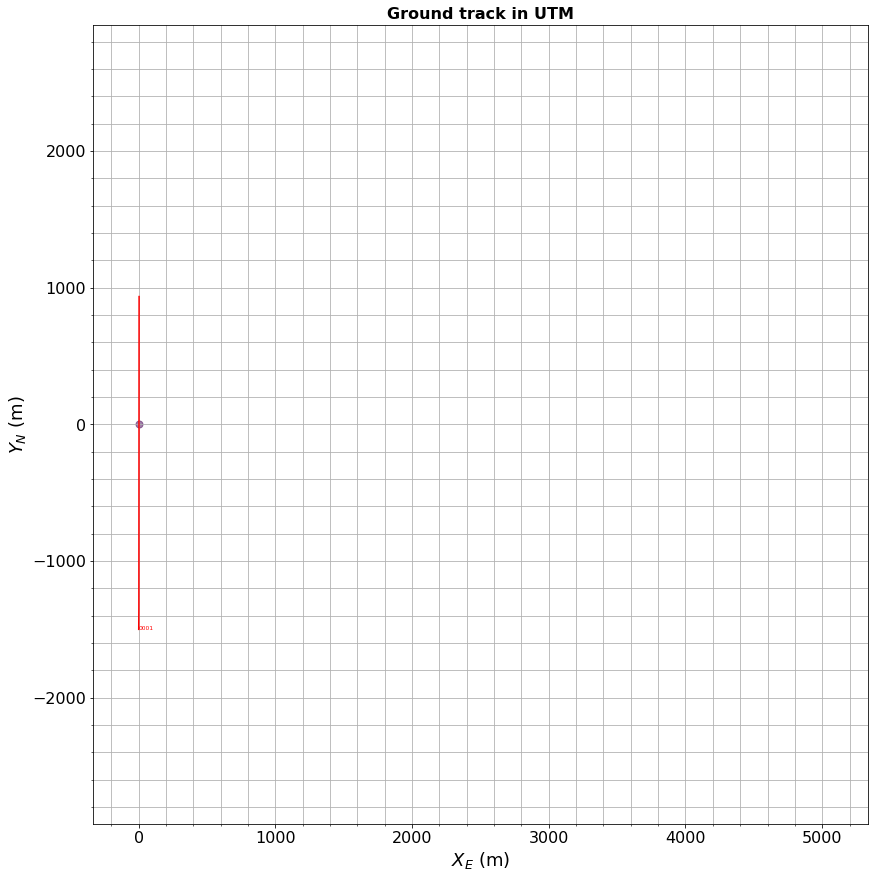

In [8]:
GrA.plot_ground_track_UTM(origin=[X_t, Y_t], ax_lim=[-500, +5500, -3000, +3000], lbl_idx=0)
#GrA.plot_traj3D_UTM(origin=[X_t, Y_t], to_scale='XY', ax_lim=[0,5000,-2500,2500,80,160], \
#                    nticks=[11,11,9], view=(10,180), legend='on')

Total time required: 0.20 s


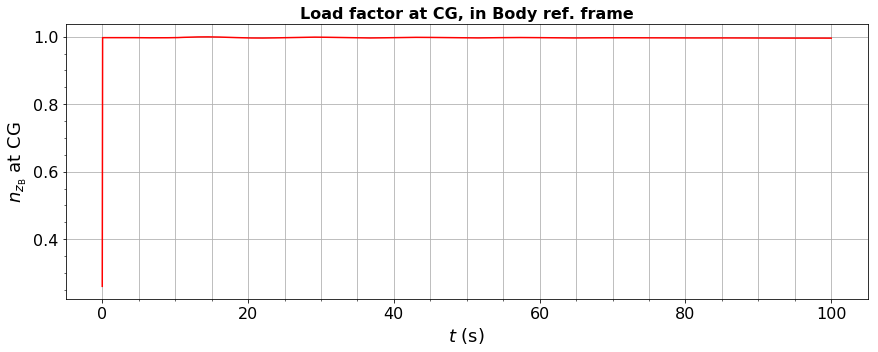

In [9]:
#GrA.plot_vars('n_x','n_y','n_z')
GrA.plot_vars('n_z')

In [10]:
def takeClosest(myList, myNumber):
    
    from bisect import bisect_left
    
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return pos, myList[0]
    if pos == len(myList):
        return pos, myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return pos, after
    else:
        return pos, before
    
    
def getCrossingPoints(MCSimGroup, XY_turb, windDir):
    
    Xt = XY_turb[0]  ; Xt = XY_turb[1]
    
    Yw = np.linspace(Y_t - 500, Y_t + 500, len(MCSimGroup.group['0001'].J[pmap['t']['property']]))
    Xw = Xt + np.tan(windDir)*np.array(Yw - Y_t)    
    
    deltaX = list(np.asarray(MCSimGroup.group['0001'].P['Nutm_m']) - Xw)
    return takeClosest(deltaX, 0)

In [11]:
a, b = getCrossingPoints(GrA, (X_t, Y_t), 270); a, b #1169

(1181, 0.3133898386731744)

In [12]:
GrA.group['0001'].J[pmap['h_agl_m']['property']][a]

118.01562992448807